# Time series

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from itertools import product
from operator import itemgetter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

Load the [TfL Cycle Hire](https://data.london.gov.uk/dataset/number-bicycle-hires) data set.

In [21]:
hires = pd.read_excel('datasets/tfl-daily-cycle-hires.xls', sheet_name='Data')

Extract time series of daily hires.

In [22]:
hires = hires.set_index('Day')\
             .loc[: ,'Number of Bicycle Hires']\
             .astype(float)\
             .resample('d')\
             .sum()

In [23]:
hires.head()

Day
2010-07-30    6897.0
2010-07-31    5564.0
2010-08-01    4303.0
2010-08-02    6642.0
2010-08-03    7966.0
Freq: D, Name: Number of Bicycle Hires, dtype: float64

Plot time series.

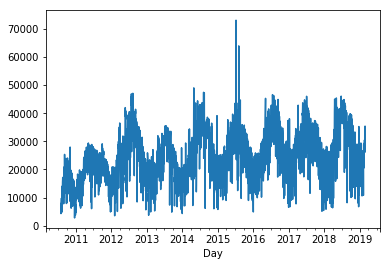

In [24]:
hires.plot()

## Aggregation

Resample at monthly resolution.

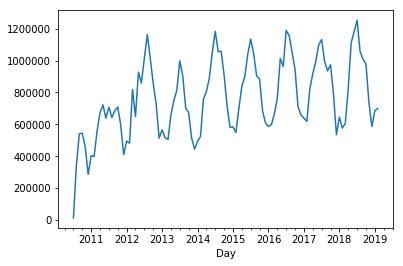

In [25]:
monthly_hires = hires.resample('M').sum()
monthly_hires.plot()

Box plots of daily hires by year, month, and weekday:

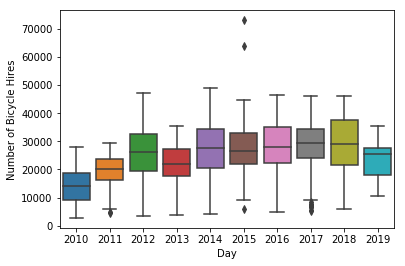

In [26]:
sns.boxplot(x=hires.index.year, y=hires)

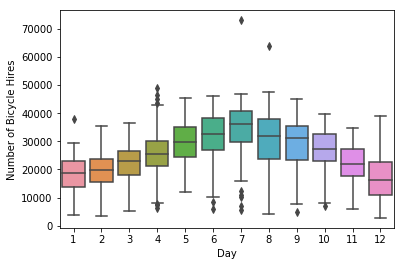

In [27]:
sns.boxplot(x=hires.index.month, y=hires)

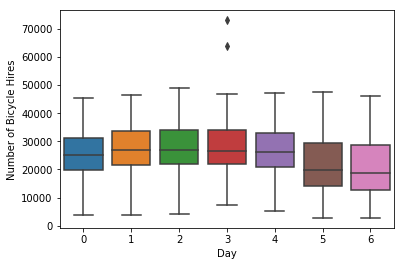

In [28]:
sns.boxplot(x=hires.index.weekday, y=hires)

## Rolling and exponentially weighted averages

### Rolling average

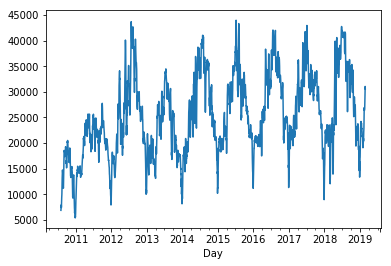

In [29]:
hires.rolling(window=7, center=True).mean().plot()

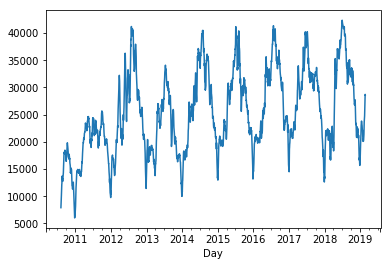

In [30]:
hires.rolling(window=14, center=True).mean().plot()

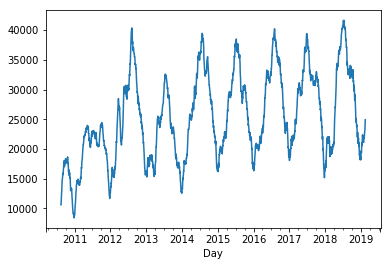

In [31]:
hires.rolling(window=30, center=True).mean().plot()

### Exponentially weighted moving average

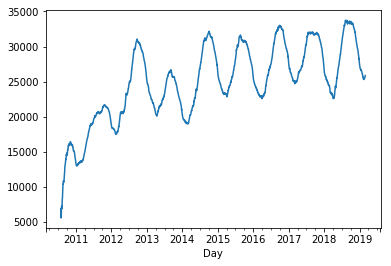

In [32]:
hires.ewm(alpha=0.01).mean().plot()
# the smaller the alpha the smoother it gets

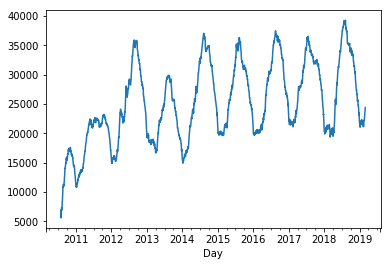

In [34]:
hires.ewm(alpha=0.03).mean().plot()

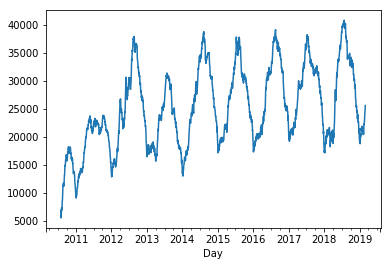

In [35]:
hires.ewm(alpha=0.05).mean().plot()

### Expanding average

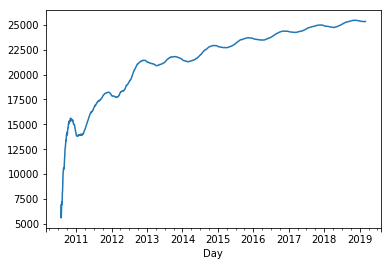

In [36]:
hires.expanding().mean().plot()

## Autocorrelation and stationarity

### Autocorrelation function (ACF)

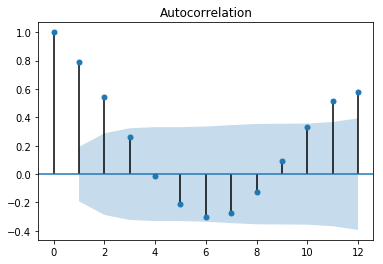

In [37]:
plot_acf(monthly_hires, lags=12);

# x axes: lags
# each point is the correlation of that month to the previous month (0), 2 previous months...


### Partial autocorrelation function (PACF)

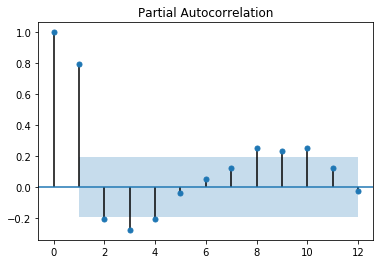

In [38]:
plot_pacf(monthly_hires, lags=12);

### Rolling statistics

In [39]:
def plot_rolling_statistics(ts):
    rolling_stats = ts.rolling(window=3).agg(['mean', 'std'])
    plt.plot(ts, color='gray', label='Original')
    plt.plot(rolling_stats['mean'], color='red', label='Rolling mean')
    plt.plot(rolling_stats['std'], color='blue', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.show(block=False)

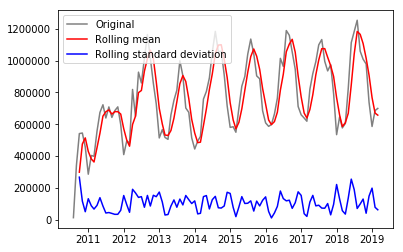

In [40]:
plot_rolling_statistics(monthly_hires)

### Augmented Dickey-Fuller test

*Note*: small $p$-values suggest stationarity.

In [41]:
sm.tsa.adfuller(hires)

(-3.5744510750849776,
 0.006268678644018634,
 29,
 3106,
 {'1%': -3.4324571193214357,
  '5%': -2.8624709939853425,
  '10%': -2.5672655905919584},
 61579.04152132802)

### First-order differencing to induce stationarity

In [42]:
monthly_hires_diff = monthly_hires.diff(1).dropna()

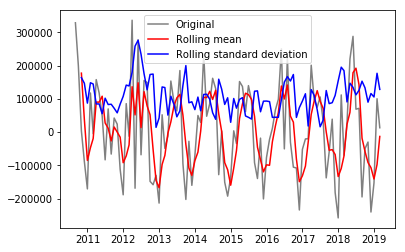

In [43]:
plot_rolling_statistics(monthly_hires_diff)

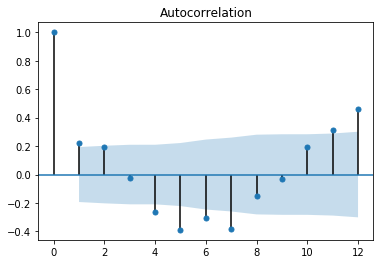

In [44]:
plot_acf(monthly_hires_diff, lags=12);

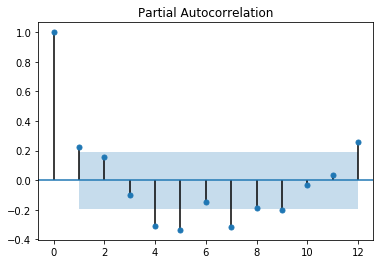

In [45]:
plot_pacf(monthly_hires_diff, lags=12);

In [46]:
sm.tsa.adfuller(monthly_hires_diff)

(-8.408727504689681,
 2.1323532808279138e-13,
 8,
 94,
 {'1%': -3.5019123847798657,
  '5%': -2.892815255482889,
  '10%': -2.583453861475781},
 2305.2467220450962)

## ARIMA modelling

Try a few $(p, d, q)$ combinations.

In [47]:
ps = range(3)
ds = range(2)
qs = range(3)

models = []

for order in product(ps, ds, qs):
    try:
        model = sm.tsa.ARIMA(monthly_hires, order).fit()
    except:
        pass
    if not model.mle_retvals['converged']:
        continue
    mape = np.mean(np.abs(monthly_hires - model.predict()) /
                   np.abs(monthly_hires))
    models.append({
        'order': order,
        'mape': mape,
    })

models.sort(key=itemgetter('mape'))

C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

In [48]:
models

[{'order': (2, 0, 2), 'mape': 0.7096231586466059},
 {'order': (2, 0, 1), 'mape': 0.7161435119915539},
 {'order': (1, 0, 2), 'mape': 0.7190859238409426},
 {'order': (2, 0, 0), 'mape': 0.7208176027046247},
 {'order': (1, 0, 1), 'mape': 0.723374237399962},
 {'order': (1, 0, 0), 'mape': 0.7271503148708427},
 {'order': (0, 0, 1), 'mape': 0.7623678554337032},
 {'order': (0, 0, 2), 'mape': 0.7623678554337032},
 {'order': (0, 0, 0), 'mape': 0.8593220396084491},
 {'order': (0, 1, 0), 'mape': 0.9904995531388148},
 {'order': (0, 1, 1), 'mape': 0.9930974377221593},
 {'order': (1, 1, 0), 'mape': 0.9949034681521995},
 {'order': (1, 1, 1), 'mape': 0.9949034681521995},
 {'order': (0, 1, 2), 'mape': 0.9982297038569354},
 {'order': (2, 1, 0), 'mape': 0.9982787581815818},
 {'order': (2, 1, 1), 'mape': 0.9982787581815818},
 {'order': (2, 1, 2), 'mape': 1.0000707880566801},
 {'order': (1, 1, 2), 'mape': 1.0068880417592145}]

Refit model with 'optimal' `order`.

In [49]:
model = sm.tsa.ARIMA(monthly_hires, models[0]['order']).fit()

In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARMA Model Results                                
===================================================================================
Dep. Variable:     Number of Bicycle Hires   No. Observations:                  104
Model:                          ARMA(2, 2)   Log Likelihood               -1361.404
Method:                            css-mle   S.D. of innovations         115954.658
Date:                     Sat, 20 Apr 2019   AIC                           2734.807
Time:                             14:56:06   BIC                           2750.673
Sample:                         07-31-2010   HQIC                          2741.235
                              - 02-28-2019                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          7.643e+05   4.36e+04     17.537      0.000    6.79e+05     8.5e+05
ar.L1.Number of Bicycle Hires     1.4902      0.143     10.433      0.000       1.210       1.770
ar.L2.Number of Bicycle Hires    -0.7117      0.126     -5.657      0.000      -0.958      -0.465
ma.L1.Number of Bicycle Hires    -0.5092      0.168     -3.024      0.003      -0.839      -0.179
ma.L2.Number of Bicycle Hires     0.3615      0.118      3.059      0.003       0.130       0.593
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0469           -0.5559j            1.1853           -0.0777
AR.2            1.0469           +0.5559j            1.1853            0.0777
MA.1            0.7043           -1.5066j            1.6631           -0.1804
MA.2            0.7043           +1.5066j            1.6631            0.1804
-----------------------------------------------------------------------------
"""

Check ACF and PACF of residuals:

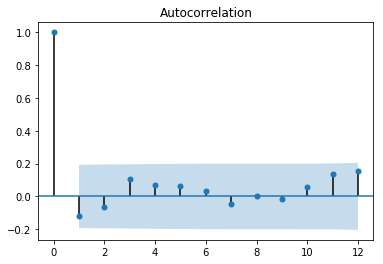

In [51]:
plot_acf(model.resid, lags=12);

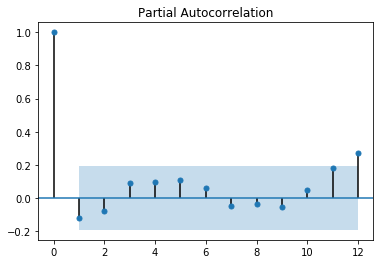

In [52]:
plot_pacf(model.resid, lags=12);

Plot predictions:

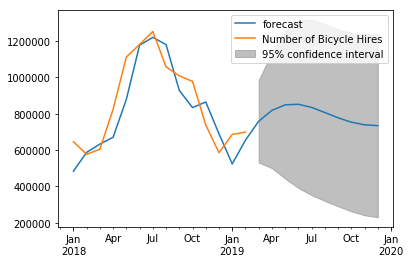

In [53]:
model.plot_predict('2018-01-31', '2019-12-31');